# Indexing Pipeline
Tax-forms come in many types ([IRS has thousands](./data/IRS-Forms.ipynb)), might be multi-page, multiple versions and layouts for the same type which makes downstream validation and classification tasks quite difficult. Our approach is to leverage form-blanks to extract most stable invariants and build a knowledge-base prior to the actual filed data starts to flow in. We make a use of both: sparse and dense representations and retrieval. We build `semantic-index` and extract form-inputs `data-schema` to be prepared to deal with any incoming visual layout variations.

If we would have to process only few classes of documents with relatively stable data-schema (required `data-input` format and structure) the simple solution would be to develop a template for each supported class, and/or UI for filling-in the required inputs. For our open-end scenario, however, the templates would be very inefficient and quite hard to maintain. Instead, we build a knowledge-base and treat document identification and data extraction as search + learning hybrid model. This notebook explores the indexing scenarios.

* [Text and layout data](#data)
* [Taxonomy for doc-identification](#taxonomy)
* [Search and retrieval: dense or sparse?](#search)
* [Form-input data-schema](#schema)

The staring point here is the `data/forms` folder with a set of pdf documents we want to index. Our target outcome should support doc-identification, data-extraction validation, domain specific search and question answering.

In [1]:
import pandas as pd
import numpy as np

from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

In [2]:
from scripts import prep, parse

<a name="conventional"></a>

## Parse info from `pdf` blanks
The `pdf` files obtained by scraping www ([see IRS example](./data/IRS-Forms.ipynb)) stored in the `data/forms` folder. The production-level setup would support a single doc uploaded by the user in addition to the `batch` scraped from the Internet.

Our pipeline target outcome:
* Extract `text and layout` info from the `pdf` and convert pages to images to [train visual models](#data)
* Extract `taxonomy-markers` (class identifiers) and index them for the [fast identification](#taxonomy)
* Encode the titles and semantically-sound text-blocks and insert into a vector database to enable [semantic search](#search)
* Extract the `data-schemas` (required data input types and labels) and cache them for the fast [retrieval by the form-identifier](#schema)

        data/
        ├── ...
        ├── IRS-Forms.ipynb
        ├── ...
        ├── forms/     --- original PDF-docs downloaded from www
        ├── images/    --- images of the doc-pages extracted from PDF
        ├── info/      --- text and layout information extracted from PDF
        ├── inputs/    --- interactive widgets information (when available) extracted from PDF
        └── ...


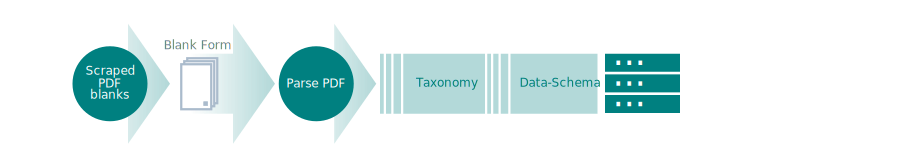

In [4]:
from IPython.display import SVG; SVG('./assets/indexing-pipeline.svg')

<a name="data"></a>

### Text and layout data exploration
The CV scenario we are exploring here is a high-precision data extraction from the scanned filled-in official documents. We assume the open-end setup: the number of the document types is expected to grow over time, the documents content and required data-input may be updated.

Our target processing success definition:
1. the document type is identified correctly
2. missing pages with expected input are identified if any
3. all filled-in fields are extracted correctly
4. all fields with missing input are identified

To support this scenario we extract the images along with text and available layout information from the pdf-form-blanks. This way we can extract the structure with confidence without distractions: it is much easier to detect inputs in the form-blank vs. the filled-in one; it is much easier to build semantic representation of the form content ([given labels](Doc-Identification-Baseline.ipynb)); finally, it is much easier to generate [synthetic data](Synthetic-Data.ipynb).

In [ ]:
# run initial parsing for exploration
!python scripts/parse.py

    IRS forms:
    extracted 94.76%
    Canada forms:
    extracted 96.75%
    Quebec forms:
    extracted 83.89%

In [6]:
# extracted page-images
images = [str(x) for x in Path(f'./data/images').glob('*.png')]

# extracted page-text
files = [str(x) for x in Path(f'./data/info').glob('*.csv.gz')]

# extracted page-inputs
forms = [str(x) for x in Path(f'./data/inputs').glob('*.csv.gz')]

print(f'Collected page samples: {len(images)}, consistent info: {len(files) >= len(images)}, '
      f'form-inputs data available: {len(forms)/len(images):.2%}')

Collected page samples: 16221, consistent info: True, form-inputs data available: 57.15%


In [7]:
docs = pd.read_csv('./data/forms.csv.gz')
docs.sample(10)

,orig,type,sub,ext,desc,lang,pages,file
493,0,8300,NaN,NaN,"Informe de Pagos en Efectivo en Exceso de $10,...",sp,6,irs-f8300sp
1417,1,T,1149,NaN,Remittance Form for Labour-Sponsored Funds Tax...,en,2,cnd-t1149.en
3356,2,CO,1029,8.36.SP,Crédit d'impôt pour des services de production...,fr,6,que-CO-1029.8.36.SP.fr
1638,1,T,2,SCH383,Manitoba Corporation Tax Calculation,en,1,cnd-t2sch383.en
3494,2,IN,231,NaN,Les transporteurs et l'Entente internationale ...,fr,24,que-IN-231.fr
2022,1,5005,S,11,"Schedule 11 - Federal Tuition, Education, and ...",en,2,cnd-5005-s11.en
1095,1,GST,115,NaN,GST/HST Rebate Application for Tour Packages,en,4,cnd-gst115.en
2261,1,RC,7246,NaN,Avis de révocation d'une renonciation pour cer...,fr,2,cnd-rc7246.fr
1090,1,XE,8,NaN,Excise Tax Act – Application for Refund of Fed...,en,2,cnd-xe8.en
3209,2,ADM,593,NaN,Analyse d'impact réglementaire – Projet de Règ...,fr,5,que-adm-593.fr


In [8]:
# page-layout data
pages = pd.read_csv('./data/page-summary.csv.gz')
pages.columns

Index(['left', 'top', 'right', 'bottom', 'font-size', 'italic', 'bold', 'cos',
       'sin', 'word-count', 'num-blocks', 'num-images', 'aspect-ratio',
       'rotation', 'scale', 'page', 'num-pages', 'source', 'check-box',
       'radio-button', 'text-input'],
      dtype='object')

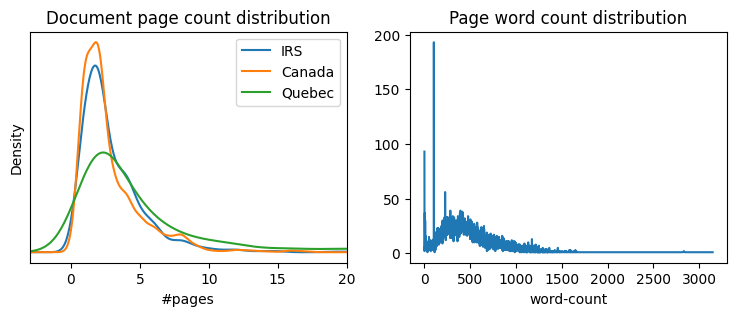

In [9]:
# plot page count stats
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
docs.loc[docs['orig']==0,'pages'].plot(kind='density', ax=ax[0], label='IRS')
docs.loc[docs['orig']==1,'pages'].plot(kind='density', ax=ax[0], label='Canada')
docs.loc[docs['orig']==2,'pages'].plot(kind='density', ax=ax[0], label='Quebec')
ax[0].set_yticks([])
ax[0].set_xlim([-3, 20])
ax[0].set_xlabel('#pages')
ax[0].set_title('Document page count distribution')
ax[0].legend()
pages.groupby('word-count').size().plot(ax=ax[1])
ax[1].set_title('Page word count distribution')
plt.show()

In [10]:
# page inputs stats
pages[['check-box','radio-button','text-input']].quantile([.5, .75, 1]).astype(int)

,check-box,radio-button,text-input
0.50,0,0,22
0.75,3,0,38
1.00,170,57,468


cnd-l302.en-0


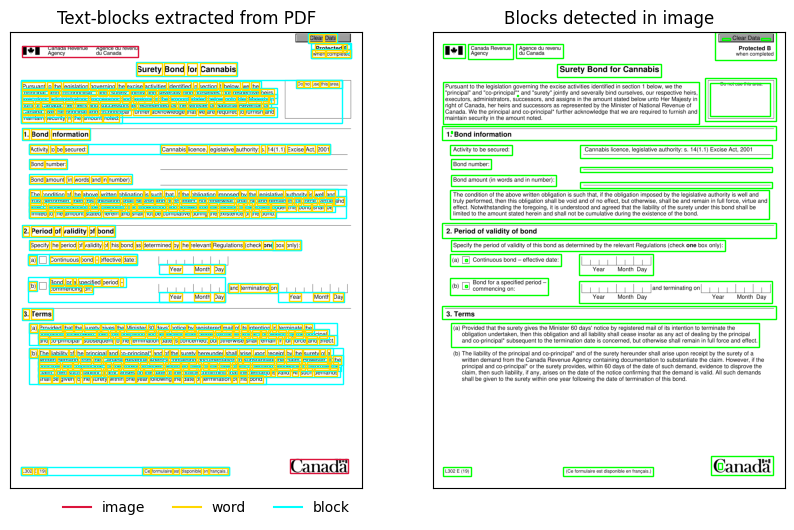

In [13]:
source = np.random.choice(forms).split('/').pop()[:-7]
#source = 'cnd-l400-2.en-0'
source = 'cnd-l302.en-0'
print(source)
image = ImageOps.grayscale(Image.open(f'./data/images/{source}.png'))
info = pd.read_csv(f'./data/info/{source}.csv.gz')
inputs = pd.read_csv(f'./data/inputs/{source}.csv.gz')

# display random image with pdf-extracted bboxes colored by type
fig, ax = plt.subplots(1, 2, figsize=(10,10))
colors = {'image':'crimson','word':'gold','block':'cyan'}
for label,color in colors.items():
    ax[0].plot([100], [100], color=color, label=label)
ax[0].imshow(image, 'gray')
for box in info[['left','top','right','bottom','scale','block-type']].values:
    x, y, x1, y1, s, t = box
    w, h = (x1 - x) * s, (y1 - y) * s
    x, y = x * s, y * s
    d = 5 if t in ['block','line'] else 0
    ax[0].add_patch(patches.Rectangle((x - d, y - d), w + d * 2, h + d * 2,
                                      linewidth=1, edgecolor=colors.get(t,'cyan'), facecolor='none'))
ax[0].set_title(f'Text-blocks extracted from PDF')
ax[0].legend(bbox_to_anchor=(1, 0), ncol=3, frameon=False)
ax[0].set_xticks([])
ax[0].set_yticks([])

# display cv2-extracted outlines
ax[1].imshow(image, 'gray')
for box in parse.extract_boxes(np.array(image)).values:
    x, y, w, h = box
    ax[1].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none'))
ax[1].set_title(f'Blocks detected in image')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

Observations:
* the header/footer areas usually have some taxonomy markers which are sufficient to identify the type, sometimes there's also a logo image which hints the doc origin
* the page orientation could be confusing: we have to parse `rotation` value carefully to use as label for the page orientation detection
* aggregated text `blocks` could be misleading: ther's a mixed signal for both the layout-blocks and the text-blocks detection
* `word` blocks should be filtered carefully to use for text detection/extraction
* `image` blocks could have textual content, while logo-image could be a part of a background (have no block) which make it hard to rely on pdf-identified presence of text or image

Conclusion:

There are inconsistencies making this PDF-dataset insufficient on its own for making reliable labels for anything but plain text extraction. Sometimes some text may appear as a part of the background image, as well as form outlines, in that case they won't appear in PDF-data. To make good labels for layout and image-blocks we have to use additional resources (like OpenCV).

The presence of taxonomy markers in the header/footer simplifies identification, however, it is still a significant challenge for OCR due to taxonomy markers being alpha-numeric patterns: more sensitive to misses vs. the plain text we can spell-correct.

<a name="taxonomy"></a>

### [Taxonomy for doc-identification](Taxonomy-Trie.ipynb)
The form type identification is straight forward if we know what we are looking for (we've got a list of expected patterns) and where to look (header and footer areas). The OCR challenge is that the patterns come with variations: spaces, dashes, etc. which may randomly appear. To make pattern-search more resistant to OCR misses and keep it fast despite of growing taxonomy we can use:
* stemming (ignore all non-essential characters and symbols)
* encoding (use symbolic representation instead of the actual thing)

Then we build a trie-index to store those (cached in RAM), and scan the header/footer areas for identification. We only need to run extensive pattern match in the case our trie-search miss.

In [12]:
# show IRS forms "stemmed" taxonomy interactive example
sunburst = parse.build_taxonomy_tree(docs[docs['orig']==0]['file'].apply(lambda x:x[5:]), 'IRS')
parse.interactive_chart(sunburst, './assets/irs-taxonomy.html')

<a name="search"></a>

### [Search and retrieval: dense + sparse](./Doc-Indexing-Pipeline.ipynb)
We need the ability to navigate our data. Our challenges with designing a search and retrieval strategy:
* some forms do not have enough of textual content, and rely on external knowledge (indexing instructional booklets for semantic search when available would be helpful)
* the documents have a significant contextual and semantic overlap and require sharp distinction at the same time (exact and keyword match search would be helpful)

Means, we need both: dense and sparse representation and retrieval.

#### 1. Dense: semantic embeddings
We take the titles and instructional pages encoded with pretrained encoder. The `distiluse-base-multilingual-cased-v1` from `sentence-transformers` worked out ok for the starter, however, using pretrained encoder without fine-tuning may not be good enough in our case.
As a storage we used [Qdrant vector database](https://qdrant.tech/): open-source, `Rust`-fast, supports text and image embeddings.

In [14]:
from scripts.search import SemanticSearch

search = SemanticSearch()
search.find('taxes related to children')

[{'ext': '',
  'lang': 'en',
  'orig': 0,
  'taxonomy': '8615',
  'text': 'Tax for Certain Children Who Have Unearned Income'},
 {'ext': '',
  'lang': 'en',
  'orig': 0,
  'taxonomy': '15110',
  'text': 'Additional Child Tax Credit Worksheet'},
 {'ext': 'EN',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'IM30',
  'text': "Entente entre exploitants associés relative à l'impôt minier"},
 {'ext': 'V',
  'lang': 'en',
  'orig': 2,
  'taxonomy': 'IN103',
  'text': 'Refundable Tax Credit for Childcare Expenses'},
 {'ext': '',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'IN103',
  'text': "Le crédit d'impôt remboursable pour frais de garde d'enfants"},
 {'ext': '29.E',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'CO1175',
  'text': 'Entente relative à la taxe sur les services publics'},
 {'ext': '8.63',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'TP1029',
  'text': "Crédit d'impôt pour frais d'adoption"},
 {'ext': '13',
  'lang': 'fr',
  'orig': 2,
  'taxonomy': 'LM93',
  'text': 'Contestation en

#### 2. Sparse: you know for search...
We indexed text-blocks and data-inputs in [ElasticSearch database](https://www.elastic.co/) which allows us to search for phrases/patterns in a specific location on the page.

In [14]:
from scripts.search import DocSearch

search = DocSearch()
search.get_docs('W2')['buckets']

[['TYPE: Text NAME: f1_02 LABEL: nan',
  "a Employer's name, address, and ZIP code"],
 ['TYPE: Text NAME: f1_03 LABEL: nan',
  "PAYER'S federal identification number PAYER'S telephone number"],
 ['TYPE: Text NAME: f1_04 LABEL: nan', "b Employer's Federal EIN"],
 ['TYPE: Text NAME: f1_08 LABEL: nan', "f Employee's address and ZIP code"],
 ['TYPE: Text NAME: f1_11 LABEL: nan', 'W-2'],
 ['TYPE: Text NAME: f1_13 LABEL: nan', '8 Cashier'],
 ['TYPE: Text NAME: f1_14 LABEL: nan', '20'],
 ['TYPE: Text NAME: f1_28 LABEL: nan', 'Previously reported'],
 ['TYPE: Text NAME: p2-t1 LABEL: nan',
  "c Employer's name, address, and ZIP code"],
 ['TYPE: Text NAME: p2-t2 LABEL: nan', "WINNER'S name"],
 ['TYPE: Text NAME: p2-t4 LABEL: nan', '(Rev. January 2021)'],
 ['TYPE: Text NAME: p2-t5 LABEL: nan', '9 10 Dependent care benefits'],
 ['TYPE: Text NAME: p2-t6 LABEL: nan',
  'BB--Designated Roth contributions under a section 403(b) plan'],
 ['TYPE: Text NAME: p2-t7 LABEL: nan', '13 Statutory employee'],
 [

In [ ]:
search.find_inputs(doc, input_type='CheckBox')

The input search utility is useful due to we cannot relay on the PDF-extracted inputs data: as you can see above their `labels` might be useless on its own, we have to rely on spacial relations on the page like nearest `top` or `left` textual content to build the data-schema with semantic link.

<a name="schema"></a>

### [Form-input data-schema](./Doc-Data-Schema.ipynb)
* The interactive pdf-form-blanks have information on the form-inputs we can infer the `data-schema` from, unfortunately it is not "user-friendly" for that kind of inference
* The visual input detection and identification can provide some help: the presence of a white space and outlines hints the expected input, spacial proximity to the text above and on the right hints the label.

We have to combine both to extract the data-schema.

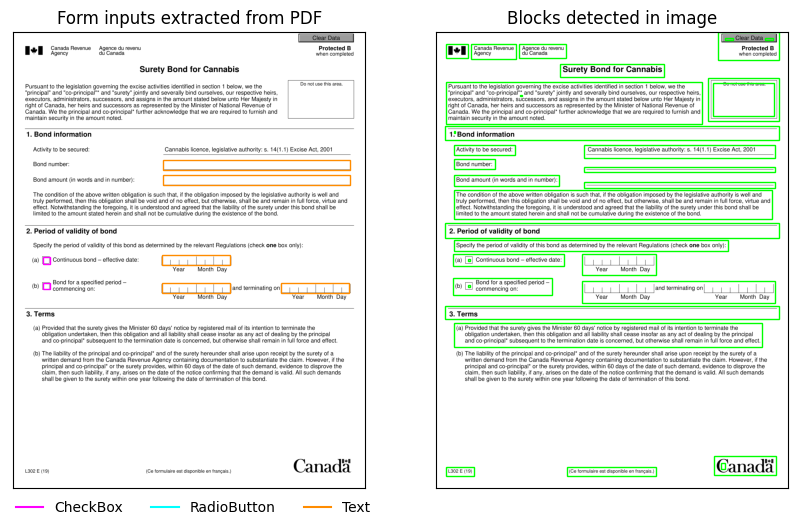

In [15]:
inputs = inputs.loc[inputs['field_type_string']!='Button']
colors = {'CheckBox':'magenta','RadioButton':'cyan','Text':'darkorange'}
fig, ax = plt.subplots(1, 2, figsize=(10,10))
for label in colors:
    ax[0].plot([100], [100], color=colors[label], label=label)
ax[0].imshow(image, 'gray')
for box in inputs[['left','top','right','bottom','field_type_string']].values:
    x, y, x1, y1, t = box
    w, h = (x1 - x) * s, (y1 - y) * s
    x, y = x * s, y * s
    ax[0].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[t], facecolor='none'))
ax[0].set_title(f'Form inputs extracted from PDF')
ax[0].legend(bbox_to_anchor=(1.05, 0), ncol=3, frameon=False)
ax[0].set_xticks([])
ax[0].set_yticks([])

# display cv2-extracted outlines
ax[1].imshow(image, 'gray')
for box in parse.extract_boxes(np.array(image)).values:
    x, y, w, h = box
    ax[1].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none'))
ax[1].set_title(f'Blocks detected in image')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

In [16]:
# form data-schema
inputs[['field_label','field_type_string']]

,field_label,field_type_string
1,1. Bond information. Bond number.,Text
2,"1. Bond information. Bond amount, in words and...",Text
3,2. Period of validity of bond. Specify the per...,CheckBox
4,2. Period of validity of bond. Continuous bond...,Text
5,2. Period of validity of bond. Specify the per...,CheckBox
6,2. Period of validity of bond. Bond for a spec...,Text
7,2. Period of validity of bond. Bond for a spec...,Text


<a name="agentic"></a>

## Use LLM-Agent to extract the knowledge
Having LangChain LLM-Agent would let us simplify not only a [form-input data-schema extraction](./agents/Expert-Agent.ipynb#schema) for a specific document, but also the bulk data inquiry: we could task the agent with [finding and gathering the data](./agents/Expert-Agent.ipynb#search) instead of writing a script for each specific case (like [IRS example](./data/IRS-Forms.ipynb)).

Our `Expert-Agent` gets the tools to communicate with databases, and its own memory index with combined visual and textual embeddings.

![](assets/indexing-agent-pipeline.svg)

An `agentic` approach sounds quite promising: our precision requirements the domain dynamics most probably would yield a rather high rate of failure for the traditional ML models and the correction pipeline would require rather heavy human involvement in the different departments in addition to the user supervision.